# Efficiency tests of the Network Diffusion library

In [1]:
%load_ext autoreload
%autoreload 2

## Necessary imports

In [2]:
from functools import partialmethod
from itertools import product

import matplotlib.pyplot as plt
import networkx as nx
import network_diffusion as nd

from utils import functions, models, time_measurements

# for purity of the notebook supress tqdm progress bar
from tqdm import tqdm
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

In [3]:
functions.set_seed(42)

## Initialise data

In [4]:
# create networks - we will use three layered ER graphs with increasing number of nodes
net_layers = [nx.erdos_renyi_graph(i, p=0.1)for i in (*range(10, 125, 5), 250, 375, 500, 750, 1000)]
ml_nets = [
    nd.MultilayerNetwork.from_nx_layer(network_layer=layer.copy(), layer_names=["contagion", "awareness"])
    for layer in net_layers
]

In [5]:
# obtain other parameters
tested_models = [models.get_ltm(), models.get_icm(), models.get_tnem(), models.get_sirua()]
num_epochs = [200]

In [6]:
# create a grid of evaluateed parameters in form of vectors (model, network, number of epochs, patience)
tested_models_params = {}
for model in tested_models:
    tested_models_params[model.__class__.__name__] = list(product([model], ml_nets, num_epochs))

## Run experiments

In [7]:
results = {}

for test_name, test_cases in tested_models_params.items():
    print(f"Evaluating: {test_name}")
    args_to_evaluate = [time_measurements.DataSample(name=params[1].get_actors_num(), data=params) for params in test_cases]
    time_enlapsed = time_measurements.time_complexity(
        function_to_analyse=time_measurements.run_model, data=args_to_evaluate, repetition_num=10
    )

    results[test_name] = time_enlapsed

Evaluating: MLTModel
Evaluating: MICModel
Evaluating: TemporalNetworkEpistemologyModel
Evaluating: SIR_UAModel


## Plot figure

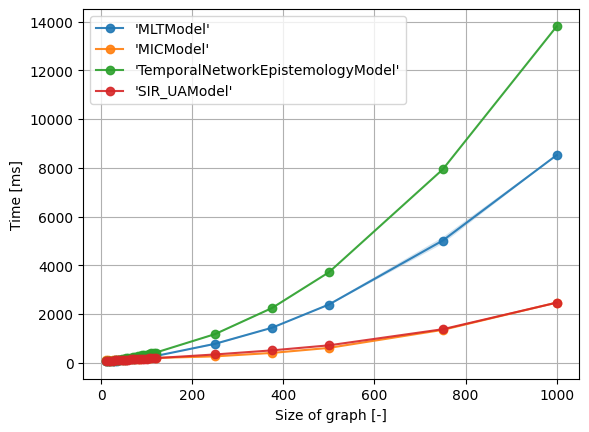

In [8]:
fig, axes = plt.subplots()
for test_name, times_enlapsed in results.items():
    time_measurements.plot_time_efficiency(times_enlapsed, test_name, axes)
    times_enlapsed.to_csv(f"efficiency_test/{test_name}.csv")
axes.set_xlabel("Size of graph [-]")
axes.set_ylabel("Time [ms]")
axes.legend(loc='upper left')
axes.grid(True)
plt.show()